# Analyzing NYC High School Data

# Introduction

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

The following analysis is based on NYC schools' data recorded in 2011. To determine the best high schools in the city, a variety of correlations are explored, such as SAT score/gender, SAT score/ethnicity, SAT score/class size, SAT score/borough location, and more.

# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as it

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

#### Students who deem safety to be a seminal school factor excel on SAT exams.

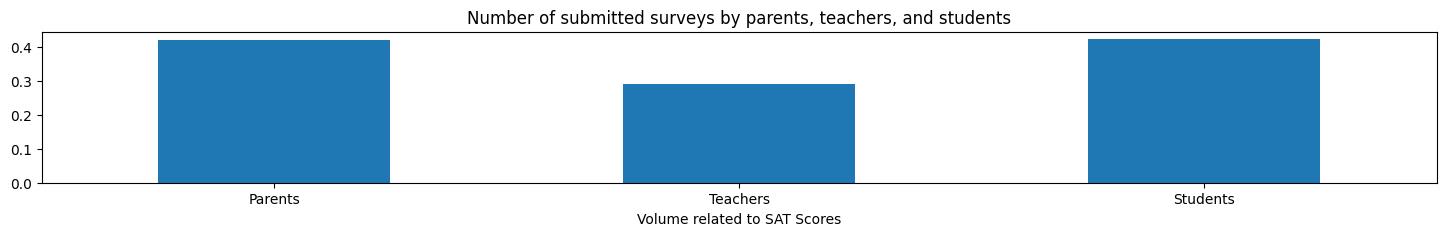

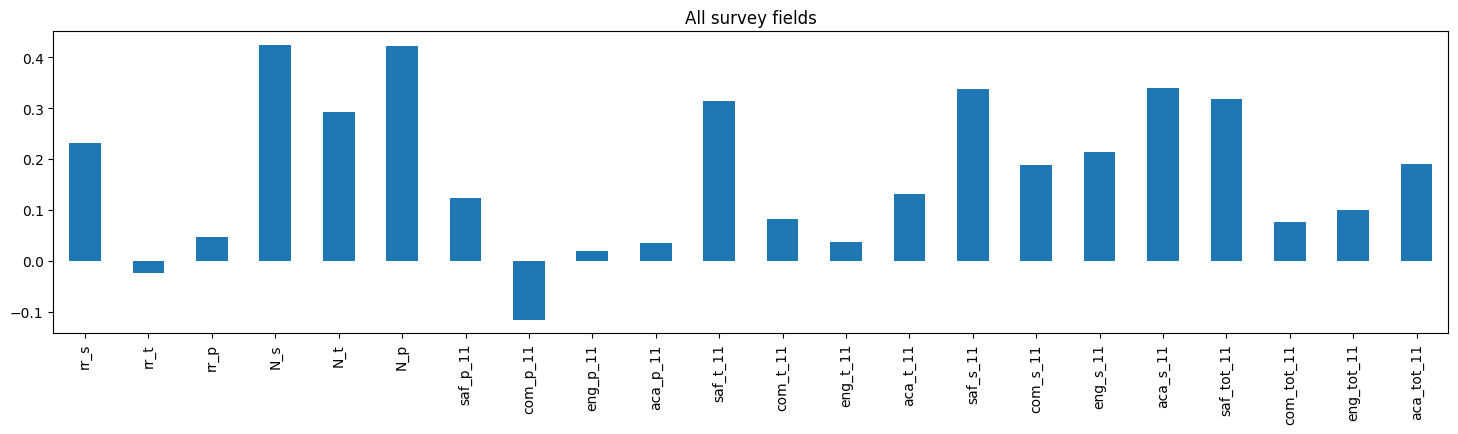

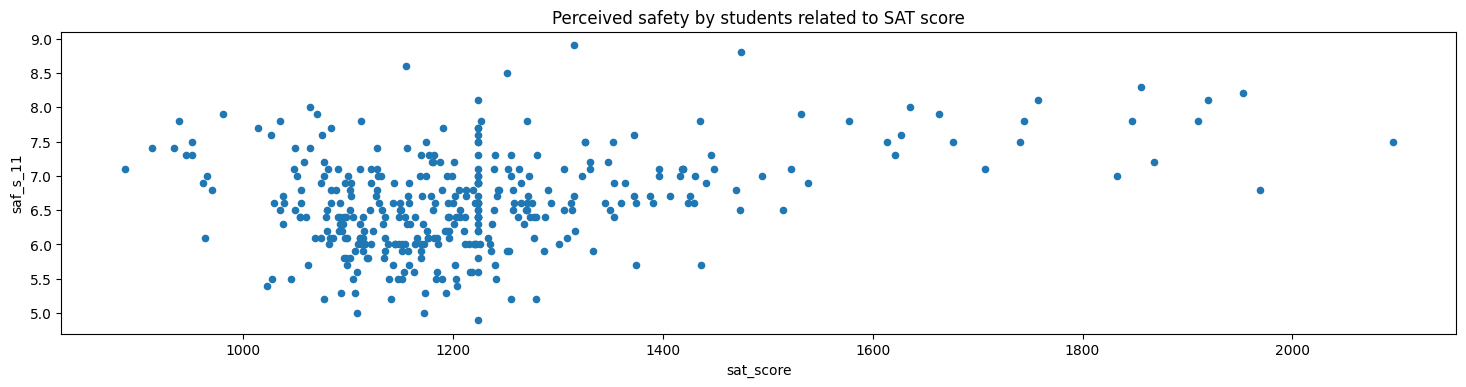

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

sat_pts_list = ['sat_score', 'N_p', 'N_t', 'N_s']
sat_pts_corr = combined[sat_pts_list].corr()['sat_score'][1:]


survey_corrs = sat_pts_corr.plot.bar(rot = 0, figsize = (18, 2))
plt.title('Number of submitted surveys by parents, teachers, and students')
plt.xlabel('Volume related to SAT Scores')
survey_corrs.set_xticklabels(['Parents', 'Teachers', 'Students'])
plt.show()

all_survey_fields_df = combined[survey_fields].corrwith(combined['sat_score'])
all_survey_fields = all_survey_fields_df.plot.bar(figsize = (18, 4))
plt.title('All survey fields')
plt.show()

saf_s_11_df = combined.plot.scatter(x = 'sat_score', y = 'saf_s_11', figsize = (18, 4))
plt.title('Perceived safety by students related to SAT score')
plt.show()

## Average safety score by borough

#### The perceived safety is highest in Manhattan, followed by Queens, and The Bronx

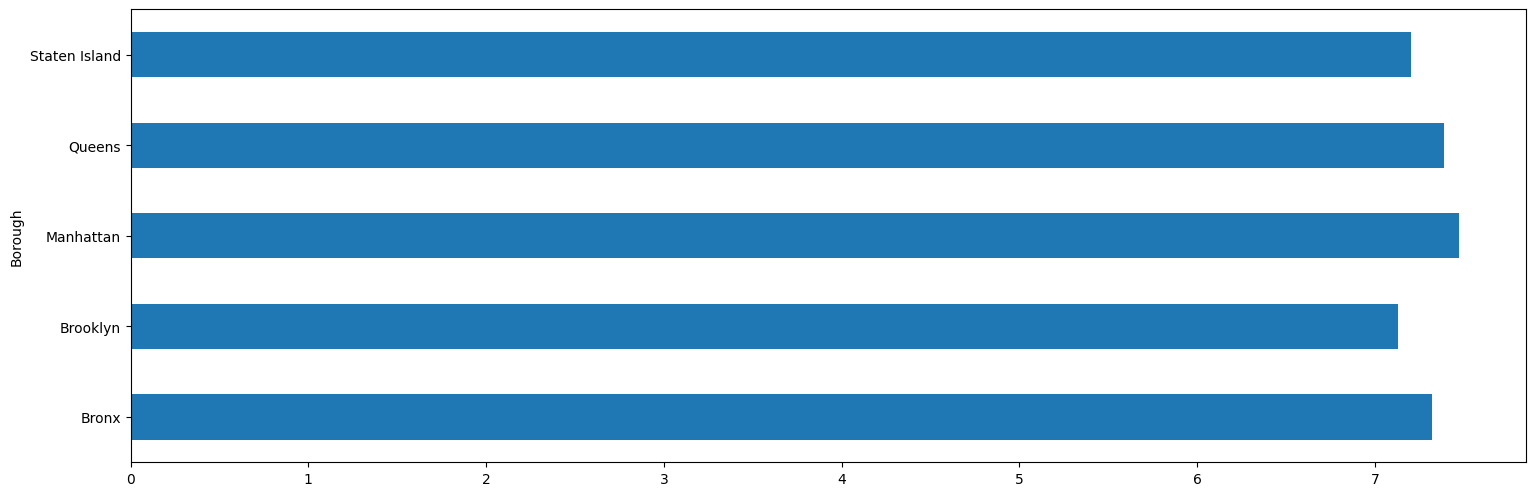

In [11]:
avg_saf_bor = combined.groupby('boro')['saf_tot_11'].agg('mean')

avg_saf_bor_plot = avg_saf_bor.plot.barh(figsize = (18, 6))
plt.ylabel('Borough')
plt.show()

In [12]:
pip install folium

     |████████████████████████████████| 102 kB 3.3 MB/s ta 0:00:01
You should consider upgrading via the '/dataquest/system/env/python3/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## In-depth display of perceived safety according to students
##### Color gradient: red(least safe), green(most safe). Hover to display a school name, click to display a borough

In [13]:
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm


# survey_fields
# survey
# boro


# gradient color for school safety poll by student - red(min), green(max)
linear = cm.LinearColormap(['red', 'green'], vmin = combined['saf_s_11'].min(), vmax = combined['saf_s_11'].max())

map_saf_s_11 = folium.Map(location = [combined['lat'].mean(), combined['lon'].mean()], zoom_start = 10.5, layout = 'constrained', tiles = 'Stamen Terrain')
for idx, row in combined.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        tooltip = row['school_name'],
        popup = row['boro'],
        fill_color = linear(row['saf_s_11']),
        color = 'white',
        radius = 6,
        weight = 1,
        fill_opacity = 1).add_to(map_saf_s_11)

map_saf_s_11

## SAT score related to ethnic groups 

           white_per  asian_per  black_per  hispanic_per
sat_score                                               
1.0         0.620718    0.57073  -0.284139     -0.396985 



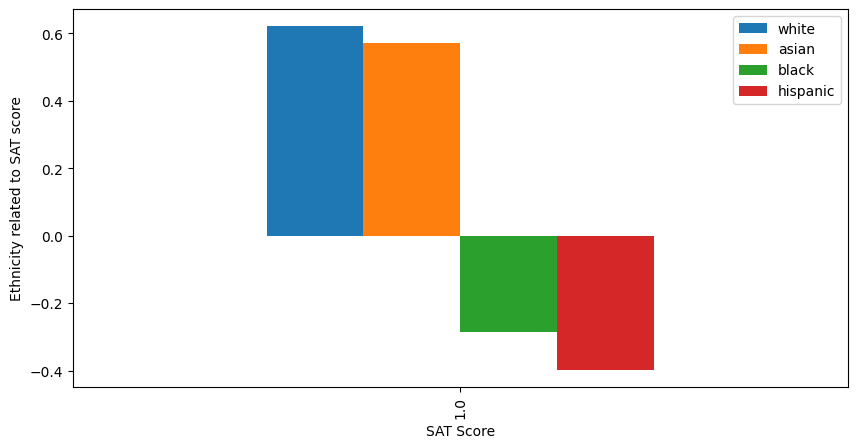

In [14]:
sat_r_dem = combined[['sat_score', 'white_per', 'asian_per', 'black_per', 'hispanic_per']].corr()
sat_r_dem.set_index('sat_score', inplace = True)
sat_r_dem = sat_r_dem.iloc[:1, :]

print(sat_r_dem, '\n')

sat_r_dem_plot = sat_r_dem.plot.bar(figsize = (10, 5))
plt.xlabel('SAT Score')
plt.ylabel('Ethnicity related to SAT score')
plt.legend(['white', 'asian', 'black', 'hispanic'])
plt.show()

## Schools with more Hispanic population display lower SAT scores

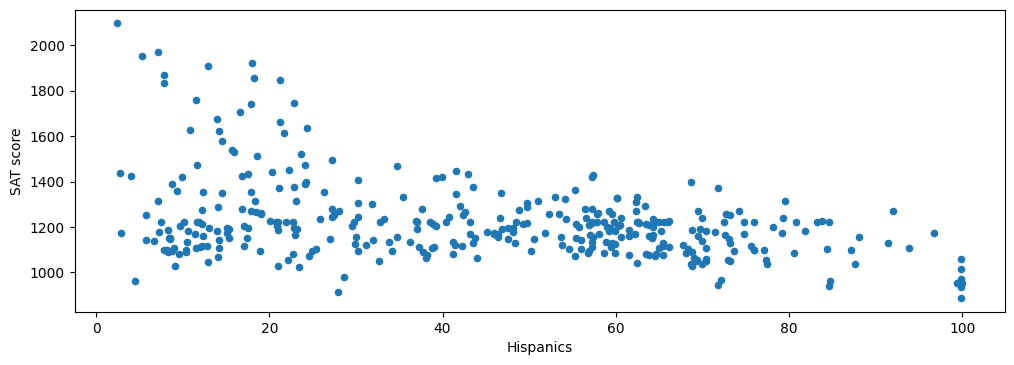

In [15]:
hisp_sat = combined.plot.scatter('hispanic_per', 'sat_score', figsize = (12, 4))
plt.xlabel('Hispanics')
plt.ylabel('SAT score')
plt.show()

## Schools with Hispanic population more than 95%
### Highest concentration in Manhattan, and The Bronx

#### Hover for school name, select for borough

In [16]:
hisp_school_95 = combined[combined['hispanic_per'] > 95][['school_name', 'lat', 'lon', 'boro']]

def borough_color(boro):
    if boro['boro'] == 'Manhattan':
        return 'green'
    elif boro['boro'] == 'Bronx':
        return 'red'
    elif boro['boro'] == 'Brooklyn':
        return 'yellow'
    elif boro['boro'] == 'Queens':
        return 'orange'
    else:
        return 'violet'

hisp_school_95['color'] = hisp_school_95.apply(borough_color, axis = 1)
    
hisp_school_95_map = folium.Map(
    location = [hisp_school_95['lat'].mean(), hisp_school_95['lon'].mean()],
    zoom_start = 11,
    tiles = 'Stamen Terrain',
    layout = 'Constrained',
    fill_color = 'green'
)

for idx, row in hisp_school_95.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        weight = 2,
        radius = 10,
        color = 'white',
        fill_color = row['color'],
        fill_opacity = .9,
        popup = row['boro'],
        tooltip = row['school_name']
    ).add_to(hisp_school_95_map)

hisp_school_95_map

## Schools with Hispanic population < 10% and average SAT score > 1800
#### Hover for school name, select for borough

In [17]:
hisp_sch_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)][['school_name', 'lat', 'lon', 'boro']]

hisp_sch_10_map =  folium.Map(
    location = [hisp_sch_10['lat'].mean(), hisp_sch_10['lon'].mean()],
    layout = 'Constrained',
    tiles = 'Stamen Terrain',
    zoom_start = 10
)

for idx, row in hisp_sch_10.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        radius = 13,
        weight = 1,
        color = 'white',
        fill_color = 'green',
        fill_opacity = .9,
        tooltip = row['school_name'],
        popup = row['boro']
    ).add_to(hisp_sch_10_map)

hisp_sch_10_map

### Ethnicity population based on schools with less than 10% Hispanics and SAT score over 1800

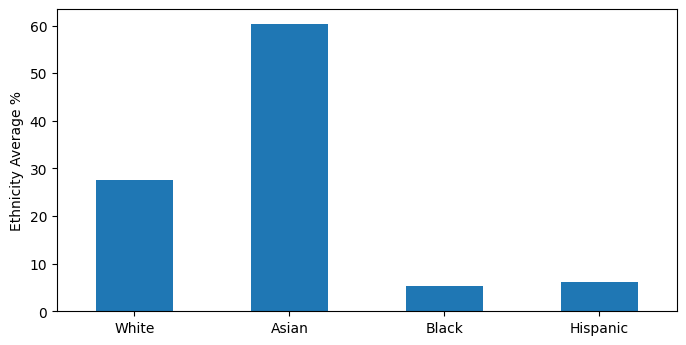

In [18]:
hisp_10_corr = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)][['school_name', 'white_per', 'asian_per', 'black_per', 'hispanic_per']].agg('mean')

hisp_10_corr_plot = hisp_10_corr.plot.bar(x = 'school_name', y = ['white_per', 'asian_per', 'black_per', 'hispaninc_per'], figsize = (8, 4))
hisp_10_corr_plot.set_xticklabels(['White', 'Asian', 'Black', 'Hispanic'])
plt.xticks(rotation = 0)
plt.ylabel('Ethnicity Average %')
plt.show()

## Gender related to SAT scores

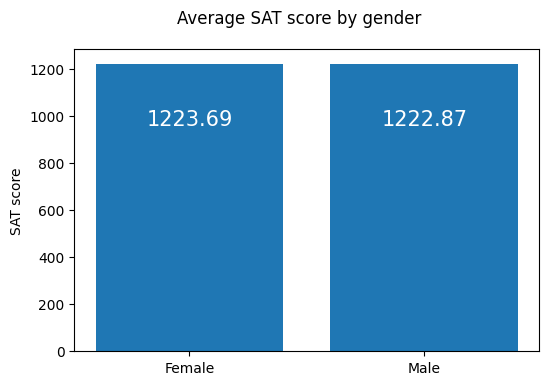

In [19]:
fem_sat_avg = combined[combined['female_per'] > 0]['sat_score'].agg('mean')
male_sat_avg = combined[combined['male_per'] > 0]['sat_score'].agg('mean')


# print(fem_sat_avg, '\n', male_sat_avg)


fig, axs = plt.subplots()
axs.bar(['Female', 'Male'], [fem_sat_avg, male_sat_avg])
# axs.text(0, 110, fem_sat_avg, va = 'bottom', ha = 'center', color = 'white')
# axs.text(1, 110, male_sat_avg, va = 'bottom', ha = 'center', color = 'w')
plt.suptitle('Average SAT score by gender')
plt.ylabel('SAT score')

for bar in axs.patches:
    axs.annotate(format(bar.get_height(), '.2f'),
                (bar.get_x() + bar.get_width() / 2,
                 bar.get_height()), ha = 'center', va = 'center', color = 'w',
                 size = 15, xytext = (0, -40),
                 textcoords = 'offset points'
                )

plt.show()



## Female %  related to SAT score

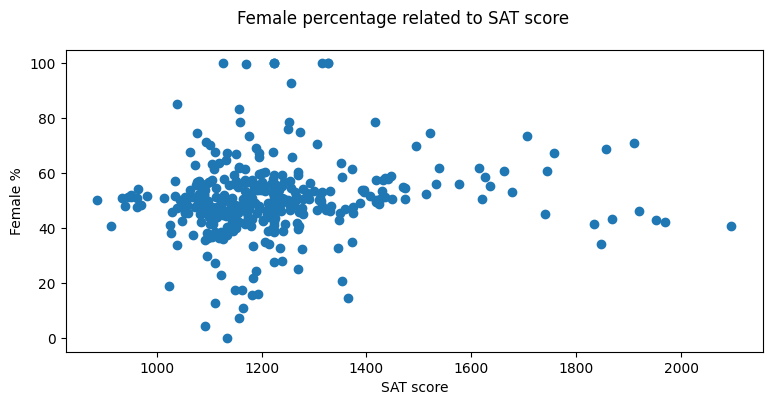

In [20]:
fig, ax = plt.subplots(figsize = (9, 4))
fem_pct_sat = ax.scatter(combined['sat_score'], combined['female_per'])
plt.suptitle('Female percentage related to SAT score')
plt.xlabel('SAT score')
plt.ylabel('Female %')
plt.show()

## Schools with female attendance over 60% and SAT scores over 1700
## 80% of the schools are located in Manhattan
#### Hover for school name, select for borough

In [21]:
fem_60_sat_1700 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)][['school_name', 'lat', 'lon', 'boro']]

# color separation for each borough applying 'borough_color()'
fem_60_sat_1700['color'] = fem_60_sat_1700.apply(borough_color, axis = 1)

fem_60_sat_1700_map = folium.Map(
    location = [fem_60_sat_1700['lat'].mean(), fem_60_sat_1700['lon'].mean()],
    layout = 'constrained',
    zoom_start = 11.5,
    tiles = 'Stamen Terrain'
)

for idx, row in fem_60_sat_1700.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        radius = 8,
        color = 'white',
        fill_color = row['color'],
        fill_opacity = 0.9,
        weight = 1,
        tooltip = row['school_name'],
        popup = row['boro']
    ).add_to(fem_60_sat_1700_map)
    
fem_60_sat_1700_map

## Juxtaposing AP vs SAT scores
#### The AP test takers % is relatively related to the SAT scores

Text(0, 0.5, 'SAT Scores')

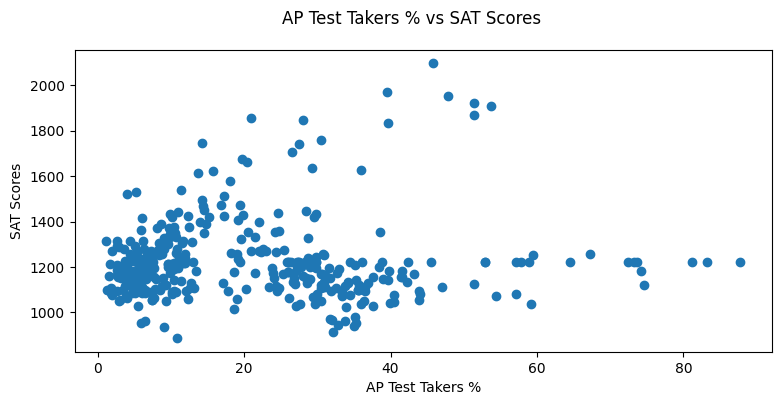

In [22]:
# AP Test Takers % based on total enrollment
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100 

fig, ax = plt.subplots(figsize = (9, 4))
ap_vs_sat = ax.scatter(combined['ap_per'], combined['sat_score'])
plt.suptitle('AP Test Takers % vs SAT Scores')
plt.xlabel('AP Test Takers %')
plt.ylabel('SAT Scores')

## Juxtaposing class size vs SAT scores
#### A larger class size significantly contributes to higher SAT scores

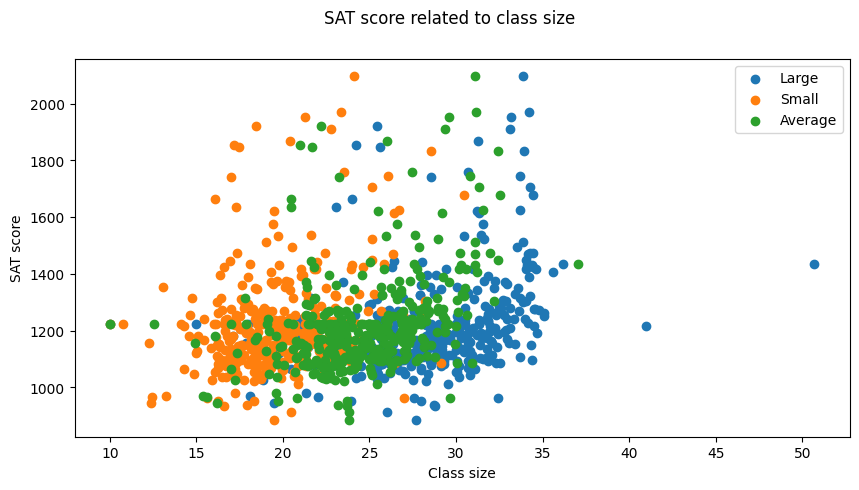

In [23]:
fig, axs = plt.subplots(figsize = (10, 5))
cls_size_corr_sat = axs.scatter(x = combined['SIZE OF LARGEST CLASS'], y = combined['sat_score'], label = 'Large')
cls_size_corr_sat_2 = axs.scatter(x = combined['SIZE OF SMALLEST CLASS'], y = combined['sat_score'], label = 'Small')
cls_size_corr_sat_3 = axs.scatter(x = combined['AVERAGE CLASS SIZE'], y = combined['sat_score'], label = 'Average')
plt.suptitle('SAT score related to class size')
plt.xlabel('Class size')
plt.ylabel('SAT score')
plt.legend()
plt.show()

## Affordable neighborhoods with best schools
#### Focusing on Queens, The Bronx, and Staten Island
#### Metrics with solid teacher, parent, and student response rate
#### Hover for school name, select for borough and district

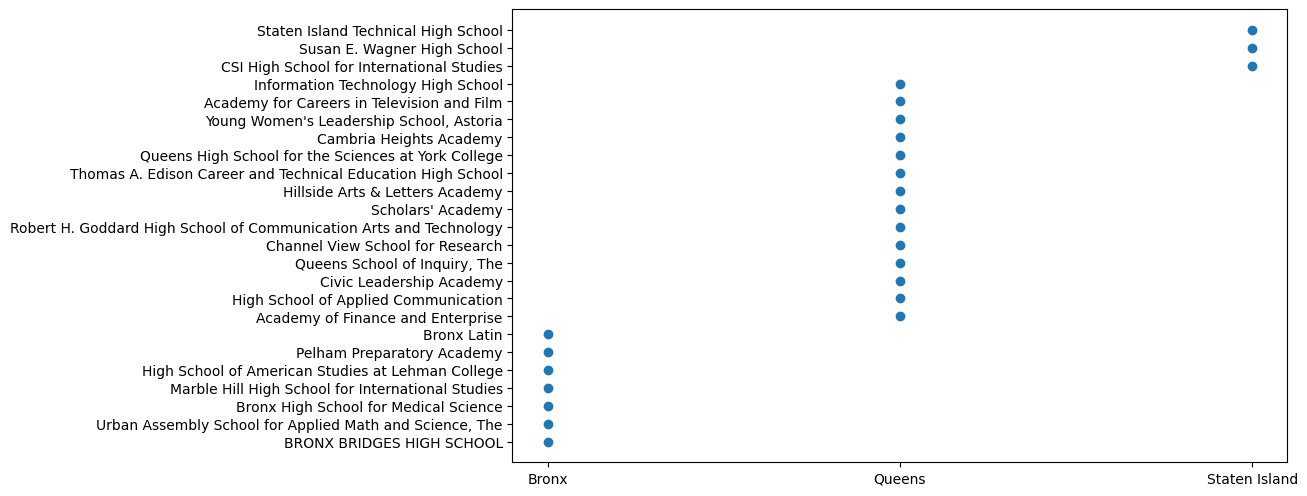

In [24]:
rr_t_s = combined[
    (combined['boro'] != 'Manhattan') &
    (combined['boro'] != 'Brooklyn') &
    (combined['sat_score'] > 1200) &
    (combined['rr_t'] > 90) &
    (combined['rr_s'] > 90) &
    (combined['rr_p'] > 20)][['boro', 'school_dist', 'school_name', 'lat', 'lon']]

plt.figure(figsize = (10, 6))

rr_t_s_s = plt.scatter(rr_t_s['boro'], rr_t_s['school_name'])
plt.show()

rr_t_s_map = folium.Map(
    location = [rr_t_s['lat'].mean(), rr_t_s['lon'].mean()],
    zoom_start = 10,
    layout = 'constrained',
    tiles = 'stamen terrain'
)

for idx, row in rr_t_s.iterrows():
    folium.CircleMarker(
        location = [row['lat'], row['lon']],
        radius = 9,
        tooltip = row['school_name'],
        popup = row['boro'] + r'\n' + f'District:{row["school_dist"]}',
        weight = 1,
        color = 'white',
        fill_color = 'blue',
        fill_opacity = 0.5,
    ).add_to(rr_t_s_map)
    
rr_t_s_map

## Conclusion

The majority of the more prefferable high schools are located in Manhattan and Brrooklyn, followed by the other three boroughs.




The metrics include:

- Safety

- SAT scores

- AP tests

- Teachers, students, and parents response rate

- Graduation rate